### Experimental Results

이제 몬테카를로 실험을 설계해 이전에 도입했던 $\text{ONC}$ 알고리즘의 정확도를 증명하고자 한다. 첫째, 미리 정한 블록수 $K$를 가진 랜덤 추출로부터 $N \times N$ 상관관계 행렬 $\rho$를 만든다. 여기서 블록 내 상관관계는 높고 블록 간 상관관계는 낮다. 둘째, 상관관계 행렬을 셔플한다. 셋째, $\text{ONC}$를 적용하고, $\text{ONC}$ 알고리즘이 투입된 블록을 복구하는 것을 증명한다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 1. Generation of Random Block Correlation Matrices


튜플 $(N, M, K)$가 주어졌을 때 각각의 크기가 $M$ 이상인 $K$ 블록으로 구성된 크기 $N \times N$의 랜덤 블록 상관관계 행렬을 만들고자 한다. $N$ 아이템을 $K$개의 분리된 그룹으로 랜덤하게 분할하는 절차를 설명할 것이다. 이는 $N' = N - K(M - 1)$ 아이템을 각 크기가 적어도 1인 $K$개의 그룹으로 랜덤하게 분할하는 것과 같으므로, 분석은 그런 식으로 간결화한다. 

집합 $A = \{1, \ldots, N'\}$로부터 집합 $B$로 표기되는 $K - 1$개의 서로 다른 아이템을 랜덤하게 선택하는 것을 고려하고, 그다음 집합 $B$의 크기가 $K$개가 되도록 $B$에 $N^\prime$을 더하자. 그러면 $B = i_1, \ldots, i_k$를 포함하게 되는데 여기서 $1 \le i_1 < i_2 < \ldots < i_k \le N'$을 고려하자. $j \ne k$가 다르다고 할 때 각 분할은 적어도 한 원소를 바라집한 것으로 포함하고, 더 나아가 집합 $\{0, \ldots, N'\}$을 완전히 분할한다. 이렇게 하면 각 집합 $C_j (j = 1, \ldots, K)$에 대해 $i_{j+1} - i_j$개의 원소를 포함한다. 여기서 $i_0 = 0$으로 설정한다. 다시 각 블록에 $M - 1$ 원소를 더함으로써 일반화할 수 있다.

각 블록 $k = 1, \dots, K$이 크기 $x_k \times x_k$를 가진다고 하면 $x_1 + \ldots + x_K = N \geq MK$를 의미한다. 여기서 $x_k \geq M$이다. 첫째, 각 블록 $k$에 대해 독립 동일 분포(i.i.d. Independent and Identically Distributed)의 표준 가우시안 분포로부터 추출한 길이 $T$의 시계열을 만들며, 크기 $(T, x_k)$ 행렬 $X$의 각 열에 이를 복제한다. 둘째, 각 $X_{i,j}$에 표준 편차 $\sigma > 0$의 랜덤 가우시안 잡음을 더한다. 설계상 $X$의 열은 작은 $\sigma$에 대해 상관관계가 높고, 큰 $\sigma$에 대해 상관관계가 낮을 것이다.

셋째, $X$의 열에 대해 공분산 행렬 $\Sigma_X$를 평가하고, $\Sigma$에 블록 $\Sigma_X$를 더한다. 넷째, $\Sigma$에 하나의 블록을 갖지만 $\sigma$이 더 큰 다른 공분산 행렬을 더한다. 마지막으로 $\Sigma$에 연관된 상관계수 행렬 $\rho$를 도출한다.

구성상 $\rho$는 각 블록 안에 높은 상관관계를 가진 $K$ 블록을 갖고, 블록 간에는 낮은 상관관계를 갖는다. 그림 3은 이런 방식으로 구축된 상관관계 행렬의 예다. 아래의 코드는 파이썬으로 이 연산을 구현한 것이다.



In [9]:
from FinancialMachineLearning.generator.pca_blocks import get_random_block_correlation

corr = get_random_block_correlation(nCols=100, nBlocks=6, random_state=0, minBlockSize=1)

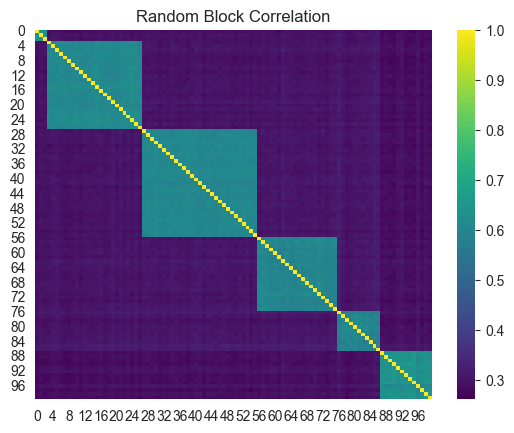

In [11]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.heatmap(corr, cmap = 'viridis')
plt.title('Random Block Correlation')
plt.show()

#### 2. Number of Clusters

위에서 소개한 절차를 사용해 적어도 $M$ 크기의 $K$ 블록을 가진 $N \times N$ 상관관계 행렬을 만든다. 각 상관관계 행렬의 행과 열을 셔플해 블록들이 더 이상 동일하지 않도록 한다. 그다음 이들 블록의 수와 구성을 복원하는 ONC 알고리즘의 유효성을 테스트한다. 시뮬레이션을 위해 $N = 20, 40, 80, 160$을 선택했다. 군집들이 적어도 2개의 객체로 구성될 것을 기대하므로 $K = 3, 6, \ldots, N/2$까지 테스트한다. 마지막으로, 이들 파라미터의 각각에 대해 1,000개의 랜덤 생성을 테스트한다.

그림 4는 이들 시뮬레이션에 대해 다양한 박스플롯(boxplot)을 보인다. 특히 주어진 버킷(bucket) 내의 $K/N$에 대해 군집화에 의해 예측된 $E[K|K]$ (진짜로 표기) 의 테스트의 실제 $K$에 대한 비율을 보인다. 이상적으로 이 비율은 1에 가까워야 한다. 결과는 ONC가 약간의 작은 오류를 갖지만 대부분 정확한 수의 군집을 복구하는 것을 보여 준다.

박스플롯 내의 중앙 박스는 바닥이 데이터의 25%(Q1)으로 설정돼 있고, 꼭대기가 75%(Q3)로 설정돼 있는 것을 상기하라. 사분위수 간의 범위인 $\text{IQR}$, Interquartile Range는 $Q3 - Q1$로 설정된다. 중앙값(median)은 박스 안의 선으로 표시된다. ‘수염(whisker)’은 $\text{Q}3 + 1.5\text{IQR}$보다 작은 것 중 가장 큰 데이터와 $\text{Q}1 - 1.5\text{IQR}$보다 큰 것 중 가장 작은 데이터까지 이어진다.


### Conclusion

Chapter 4에서는 분할 알고리즘에 의한 군집의 최적 구성과 개수를 결정하는 문제를 연구했다. $k$-means 알고리즘에 대한 세 가지 수정을 가했다.

1. 군집의 품질을 측정하는 목적 함수를 정의했다.
2. 대안 seed를 가진 알고리즘을 재실행해 k-means 평균의 초기화 문제를 해결했다.
3. 상위 수준 군집화는 평균 이하 품질을 보이는 군집들 사이에서 더 나은 분할을 찾는다.

실험 결과는 알고리즘이 블록-대각 행렬에 투입된 군집의 수와 구성을 효과적으로 복구한다는 것을 보여 준다.

제안된 해법을 랜덤 상관 행렬에 적용했지만, 이 방법은 다른 종류의 행렬에도 적용할 수 있을 것이다. 알고리즘의 시작점은 관측 행렬이며, 이는 상관관계 기반 척도, 정보 변분 또는 어떤 다른 함수로도 정의할 수 있다.